## Targeted Classifier Experiment


In [1]:
%load_ext autoreload
%autoreload 2

import sklearn
import json


with open("../../data/dataset.json") as f:
    data = json.load(f)


## Exploratorio

In [2]:
def is_mixed(instance):
    return len(set(instance["labels"].values())) >= 2

len([x for x in data if is_mixed(x)]), len(data)

(160, 1930)

In [3]:

len([x for x in data if len(x["labels"]) > 1]), len(data)

(396, 1930)

In [4]:
import pandas as pd

label2id = {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
}

id2label = {v:k for k, v in label2id.items()}

def build_auxiliary_sentence(target):
    return target

def build_df(data):
    return pd.DataFrame([{
        "id": x["id"],
        "sentence": x["titulo"],
        "target": target,
        "auxiliary_sentence": build_auxiliary_sentence(target),
        "label": label2id[label],
    } for x in data for (target, label) in x["labels"].items()])

Bien, está dentro de todo equilibrado

## Train test split

Lo hago sobre el dataset. No sería mejor hacerlo por oraciones?

In [5]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, random_state=2021, stratify=[len(x["labels"]) for x in data])

train_data, dev_data = train_test_split(train_data, random_state=2021, stratify=[len(x["labels"]) for x in train_data])

len(train_data), len(dev_data), len(test_data)

(1085, 362, 483)

## Armar dataset

In [6]:
from datasets import Dataset, Value, ClassLabel, Features

train_df = build_df(train_data)
dev_df = build_df(dev_data)
test_df = build_df(test_data)

features = Features({
    'sentence': Value('string'),
    'auxiliary_sentence': Value('string'),
    'label': ClassLabel(num_classes=3, names=["neg", "neu", "pos"])
})

columns = ["sentence", "auxiliary_sentence", "label"]

train_dataset = Dataset.from_pandas(train_df[columns], features=features)
dev_dataset = Dataset.from_pandas(dev_df[columns], features=features)
test_dataset = Dataset.from_pandas(test_df[columns], features=features)

In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = 'dccuchile/bert-base-spanish-wwm-uncased'

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, return_dict=True, num_labels=len(id2label)
)

model.config.id2label = id2label
model.config.label2id = label2id

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.model_max_length = 128


Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

In [8]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)

In [9]:
def tokenize(batch):
    return tokenizer(batch['sentence'], batch['auxiliary_sentence'], padding='max_length', truncation=True)

batch_size = 16
eval_batch_size = 8

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=batch_size)
dev_dataset = dev_dataset.map(tokenize, batched=True, batch_size=eval_batch_size)
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=eval_batch_size)

(array([ 20., 124., 218., 392., 257., 192.,  98.,  23.,   7.,   5.]),
 array([10. , 13.6, 17.2, 20.8, 24.4, 28. , 31.6, 35.2, 38.8, 42.4, 46. ]),
 <BarContainer object of 10 artists>)

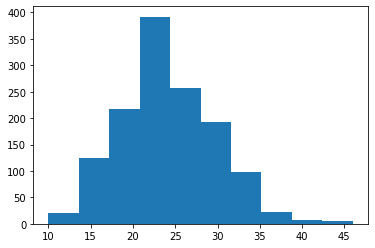

In [10]:
import matplotlib.pyplot as plt

lens = [sum(x["attention_mask"]) for x in train_dataset]


plt.hist(lens)

In [11]:
train_dataset[0].keys()

dict_keys(['attention_mask', 'auxiliary_sentence', 'input_ids', 'label', 'sentence', 'token_type_ids'])

In [12]:

def format_dataset(dataset):
    dataset = dataset.map(lambda x: {"labels": x["label"]})
    columns = ['input_ids', 'attention_mask', 'labels']
    if 'token_type_ids' in dataset.features:
        columns.append('token_type_ids')
    dataset.set_format(type='torch', columns=columns)
    return dataset

train_dataset = format_dataset(train_dataset)
dev_dataset = format_dataset(dev_dataset)
test_dataset = format_dataset(test_dataset)


In [13]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred, id2label):
    """
    Compute metrics for Trainer
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    ret = {}

    f1s = []
    precs = []
    recalls = []

    for i, cat in id2label.items():
        cat_labels, cat_preds = labels == i, preds == i
        precision, recall, f1, _ = precision_recall_fscore_support(
            cat_labels, cat_preds, average='binary', zero_division=0,
        )

        f1s.append(f1)
        precs.append(precision)
        recalls.append(recall)

        ret[cat.lower()+"_f1"] = f1
        ret[cat.lower()+"_precision"] = precision
        ret[cat.lower()+"_recall"] = recall

    _, _, micro_f1, _ = precision_recall_fscore_support(
        labels, preds, average="micro"
    )
    ret["micro_f1"] = micro_f1
    ret["macro_f1"] = torch.Tensor(f1s).mean()
    ret["macro_precision"] = torch.Tensor(precs).mean()
    ret["macro_recall"] = torch.Tensor(recalls).mean()

    ret["acc"] = accuracy_score(labels, preds)

    return ret

epochs = 5
warmup_proportion = 0.10
total_steps = (epochs * len(train_dataset)) // batch_size
warmup_steps = int(warmup_proportion * total_steps)

training_args = TrainingArguments(
    output_dir='./results/',
    num_train_epochs=epochs,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
    warmup_steps=warmup_steps,
    evaluation_strategy="epoch",
    do_eval=False,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=lambda x: compute_metrics(x, id2label=id2label),
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
)


In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Neg F1,Neg Precision,Neg Recall,Neu F1,Neu Precision,Neu Recall,Pos F1,Pos Precision,Pos Recall,Micro F1,Macro F1,Macro Precision,Macro Recall,Acc,Runtime,Samples Per Second
1,No log,0.917584,0.494297,0.464286,0.528455,0.389610,0.494505,0.321429,0.666667,0.616822,0.725275,0.543820,0.516858,0.525205,0.525053,0.543820,2.280300,195.147000
2,No log,0.844579,0.623932,0.657658,0.593496,0.532319,0.569106,0.500000,0.702290,0.654028,0.758242,0.631461,0.619514,0.626931,0.617246,0.631461,2.222500,200.224000
3,No log,0.951265,0.618321,0.582734,0.658537,0.480000,0.545455,0.428571,0.714286,0.688776,0.741758,0.620225,0.604202,0.605655,0.609622,0.620225,2.261700,196.759000
4,No log,1.084374,0.630435,0.568627,0.707317,0.507353,0.522727,0.492857,0.701754,0.750000,0.659341,0.620225,0.613181,0.613785,0.619838,0.620225,2.271700,195.888000
5,No log,1.117048,0.607004,0.582090,0.634146,0.526718,0.565574,0.492857,0.695418,0.682540,0.708791,0.620225,0.609713,0.610068,0.611932,0.620225,2.283400,194.883000


TrainOutput(global_step=420, training_loss=0.5395730154854911, metrics={'train_runtime': 146.713, 'train_samples_per_second': 2.863, 'total_flos': 563573214074880.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 54251, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18258, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 1147347, 'train_mem_gpu_alloc_delta': 1794120704, 'train_mem_cpu_peaked_delta': 95403114, 'train_mem_gpu_peaked_delta': 1338075648})

In [15]:
trainer.evaluate(dev_dataset)

{'eval_loss': 0.8445785641670227,
 'eval_neg_f1': 0.6239316239316239,
 'eval_neg_precision': 0.6576576576576577,
 'eval_neg_recall': 0.5934959349593496,
 'eval_neu_f1': 0.532319391634981,
 'eval_neu_precision': 0.5691056910569106,
 'eval_neu_recall': 0.5,
 'eval_pos_f1': 0.7022900763358779,
 'eval_pos_precision': 0.6540284360189573,
 'eval_pos_recall': 0.7582417582417582,
 'eval_micro_f1': 0.6314606741573033,
 'eval_macro_f1': 0.6195136904716492,
 'eval_macro_precision': 0.6269305944442749,
 'eval_macro_recall': 0.6172458529472351,
 'eval_acc': 0.6314606741573033,
 'eval_runtime': 2.1696,
 'eval_samples_per_second': 205.109,
 'epoch': 5.0,
 'eval_mem_cpu_alloc_delta': 63570,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 128808,
 'eval_mem_gpu_peaked_delta': 35169792}

In [16]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.7685454487800598,
 'eval_neg_f1': 0.6538461538461539,
 'eval_neg_precision': 0.7034482758620689,
 'eval_neg_recall': 0.6107784431137725,
 'eval_neu_f1': 0.6201117318435755,
 'eval_neu_precision': 0.6809815950920245,
 'eval_neu_recall': 0.5692307692307692,
 'eval_pos_f1': 0.7170542635658913,
 'eval_pos_precision': 0.6491228070175439,
 'eval_pos_recall': 0.8008658008658008,
 'eval_micro_f1': 0.6711635750421585,
 'eval_macro_f1': 0.6636707186698914,
 'eval_macro_precision': 0.6778509020805359,
 'eval_macro_recall': 0.6602916717529297,
 'eval_acc': 0.6711635750421585,
 'eval_runtime': 3.1814,
 'eval_samples_per_second': 186.398,
 'epoch': 5.0,
 'eval_mem_cpu_alloc_delta': 70478,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 175801,
 'eval_mem_gpu_peaked_delta': 35173376}

In [17]:
model = trainer.model

In [18]:
from torch.nn import functional as F
def predict(sentence, target):
    """
    Return most likely class for the sentence
    """
    idx = torch.LongTensor(tokenizer.encode(sentence, build_auxiliary_sentence(target))).view(1, -1).to(device)
    output = model(idx)
    probs = F.softmax(output.logits, dim=1).view(-1)
    probas = {id2label[i]:probs[i].item() for i in id2label}

    return probas



In [19]:
sentence = "Gran 2020 para Messi, pero bastante malo para Cristiano Ronaldo"

targets = ["Messi", "Cristiano Ronaldo"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Messi
{'NEG': 0.6690586805343628, 'NEU': 0.11109622567892075, 'POS': 0.21984511613845825}
Cristiano Ronaldo
{'NEG': 0.5807671546936035, 'NEU': 0.141855850815773, 'POS': 0.2773769199848175}


In [20]:
sentence = "Alberto Fernández: \"El gobierno de Macri fue un desastre\""

targets = ["Alberto Fernández", "Macri"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Alberto Fernández
{'NEG': 0.4442727267742157, 'NEU': 0.07180363684892654, 'POS': 0.4839235842227936}
Macri
{'NEG': 0.91265469789505, 'NEU': 0.02680148556828499, 'POS': 0.06054387241601944}


In [21]:
sentence = "Alberto Fernández: \"El gobierno de Xi Jin Ping fue un desastre\""

targets = ["Alberto Fernández", "Xi Jin Ping"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Alberto Fernández
{'NEG': 0.4194716215133667, 'NEU': 0.0903436467051506, 'POS': 0.49018481373786926}
Xi Jin Ping
{'NEG': 0.601568341255188, 'NEU': 0.07467816770076752, 'POS': 0.32375356554985046}


In [22]:
sentence = "Romina Del Plá denunció el ajuste de Alberto Fernández"

targets = ["Romina del Plá", "Alberto Fernández"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Romina del Plá
{'NEG': 0.06417309492826462, 'NEU': 0.6475261449813843, 'POS': 0.2883007228374481}
Alberto Fernández
{'NEG': 0.08538411557674408, 'NEU': 0.6179078221321106, 'POS': 0.29670801758766174}


In [23]:
sentence = "El Gobierno mejora la compra de vacunas"

targets = ["Gobierno"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
{'NEG': 0.1383291631937027, 'NEU': 0.3001222312450409, 'POS': 0.5615485906600952}


In [24]:
sentence = "Cristina Kirchner acusa al Gobierno de corrupción en la compra de vacunas"

targets = ["Gobierno", "Cristina Kirchner"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
{'NEG': 0.9003186225891113, 'NEU': 0.0459490530192852, 'POS': 0.053732261061668396}
Cristina Kirchner
{'NEG': 0.8043696880340576, 'NEU': 0.07392097264528275, 'POS': 0.12170933932065964}


In [25]:
sentence = "El duro comunicado de las empresas estadounidenses contra el Gobierno"

targets = ["Gobierno", "empresas estadounidenses"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
{'NEG': 0.862302839756012, 'NEU': 0.06734393537044525, 'POS': 0.0703531950712204}
empresas estadounidenses
{'NEG': 0.8728734254837036, 'NEU': 0.05331512913107872, 'POS': 0.07381149381399155}


In [26]:
sentence = "Ultiman negociaciones para cerrar acuerdo en la Ciudad entre Vidal y Bullrich"

targets = ["Vidal", "Bullrich"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Vidal
{'NEG': 0.39318323135375977, 'NEU': 0.48746615648269653, 'POS': 0.11935054510831833}
Bullrich
{'NEG': 0.44138288497924805, 'NEU': 0.41806885600090027, 'POS': 0.14054828882217407}


In [27]:
sentence = "\"Este Gobierno ha sido una lacra corrupta inmunda\" declaró Patricia Bullrich"

targets = ["Gobierno", "Bullrich"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
{'NEG': 0.7552647590637207, 'NEU': 0.05085083097219467, 'POS': 0.1938844621181488}
Bullrich
{'NEG': 0.6112171411514282, 'NEU': 0.09347894042730331, 'POS': 0.29530394077301025}


Si lo ponemos adelante, sin embargo...

Si lo ponemos adelante, sin embargo...

In [28]:
sentence = "Patricia Bullrich: \"Este Gobierno ha sido una lacra corrupta inmunda\""

targets = ["Gobierno", "Bullrich"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
{'NEG': 0.7232314348220825, 'NEU': 0.05712062865495682, 'POS': 0.21964794397354126}
Bullrich
{'NEG': 0.6413940191268921, 'NEU': 0.0537356473505497, 'POS': 0.3048703372478485}


In [29]:
sentence = "Keiko: 'Pedro Castillo es un pésimo dirigente, pero por suerte este Gobierno es lo mejor que le ha pasado a Perú'"

targets = ["Keiko", "Pedro Castillo", "Gobierno"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Keiko
{'NEG': 0.0744931697845459, 'NEU': 0.15313492715358734, 'POS': 0.7723719477653503}
Pedro Castillo
{'NEG': 0.11460885405540466, 'NEU': 0.1087641492486, 'POS': 0.7766269445419312}
Gobierno
{'NEG': 0.3086913526058197, 'NEU': 0.23350739479064941, 'POS': 0.4578011929988861}


In [30]:
sentence = "El contundente mensaje de L-Gante contra Cristina Kirchner: \"A mí nadie me regaló nada\""

targets = ["L-Gante", "Cristina Kirchner"]

for target in targets:
    print(target)
    print(predict(sentence, target))


L-Gante
{'NEG': 0.5695484280586243, 'NEU': 0.04332480952143669, 'POS': 0.38712671399116516}
Cristina Kirchner
{'NEG': 0.71095871925354, 'NEU': 0.04018707573413849, 'POS': 0.24885421991348267}


In [31]:
sentence = "Causa Maradona: Dalma y Gianinna denunciaron que quieren que Matías Morla se vaya"

targets = ["Dalma", "Gianinna", "Matías Morla"]


for target in targets:
    print(target)
    print(predict(sentence, target))

Dalma
{'NEG': 0.8099995255470276, 'NEU': 0.0764666199684143, 'POS': 0.1135338544845581}
Gianinna
{'NEG': 0.8513584733009338, 'NEU': 0.0592937134206295, 'POS': 0.08934776484966278}
Matías Morla
{'NEG': 0.9031091332435608, 'NEU': 0.044463928788900375, 'POS': 0.052426934242248535}


In [32]:
for instance in [x for x in test_data if is_mixed(x)]:
    print("="*80)
    print(instance["labels"])
    sentence = instance["titulo"]
    print(sentence)

    targets = instance["labels"]

    for target, label in targets.items():
        probas = pd.Series(predict(sentence, target))
        predicted_label = probas.index[probas.argmax()]

        if {predicted_label, label} == {"NEG", "POS"}:
            print(target)
            print(probas)
        elif predicted_label != label:
            print(target , f" era {label}, predijo {predicted_label}")
        else:
            print(target, " OK")

{'Mauricio Macri': 'NEG', 'Alberto Fernández': 'POS'}
Alberto Fernández cruzó a Mauricio Macri por la mención a San Martín: "Nada heroico hizo usted"
Mauricio Macri  OK
Alberto Fernández  OK
{'Mauricio Macri': 'NEU', 'Alberto Fernández': 'POS'}
Alberto Fernández le pidió a Mauricio Macri que "no libere el dólar" si pierde las elecciones
Mauricio Macri  era NEU, predijo NEG
Alberto Fernández  OK
{'Miguel Pichetto': 'POS', 'Mauricio Macri': 'POS', 'Alberto Fernández': 'NEG'}
Para Miguel Pichetto, el ganador del debate fue Mauricio Macri: “Alberto Fernández fue muy agresivo y arrogante”
Miguel Pichetto
NEG    0.655971
NEU    0.068825
POS    0.275205
dtype: float64
Mauricio Macri
NEG    0.735141
NEU    0.070548
POS    0.194311
dtype: float64
Alberto Fernández  OK
{'Mauricio Macri': 'NEG', 'Alberto Fernández': 'POS'}
Alberto Fernández cruzó a Mauricio Macri por la referencia a San Martín: “Usted solo supo entregar el país al FMI, nada heroico hizo”
Mauricio Macri  OK
Alberto Fernández  OK
{